# Preprocessing Module with Features Data
This module adds the target column of dyskinesias to features data according to MDS-UPDRS patients test.

## Required Imports

In [221]:
import os
import re


import pandas as pd
import numpy as np
import seaborn as sns

from src.settings import ROOT_DIR
from src.preprocessing.get_anon_id import get_anon_id
from src.utils.data_split import save_and_split

## Load Data
Loads Features and MDS-UPDRS

In [222]:
#Load Features
data: pd.DataFrame = pd.read_pickle(ROOT_DIR / 'data' / 'processed' / 'anon_imu_data_features.pkl')

#Load MDS-UPDRS
patients_mds:pd.DataFrame = pd.read_excel(ROOT_DIR / 'data' / 'raw' / 'patients_mdsupdrs_results.xlsx')
patients_mds_used_columns = ['Cédula','¿Discinesias presentes?']
patients_mds = patients_mds[patients_mds_used_columns]

In [223]:
patients_mds['Cédula'] = patients_mds['Cédula'].astype('string')

## MDS-UPDRS Target extraction

Is necessary to split patients and controls to cross ids with MDS-UPDRS test:

In [224]:
patients_mds['anon_id'] = patients_mds['Cédula'].apply(get_anon_id)
patients_mds_used_columns.pop(0)

'Cédula'

In [225]:
dysk_list = []
for i in range(len(patients_mds)):
    cell_value = patients_mds.loc[i, patients_mds_used_columns].item()
    if cell_value == "Sí":
        dysk_list.append(1)
    elif cell_value == "No":
        dysk_list.append(0)
    else:
        dysk_list.append(3)

In [226]:
dysk_list

[1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 3,
 3,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 3,
 1,
 0,
 1,
 1,
 3,
 3,
 3,
 3]

In [227]:
patients_mds['dyskinesias'] = dysk_list
patients_mds = patients_mds[['anon_id', 'dyskinesias']]
patients_mds['dyskinesias'].value_counts()

dyskinesias
3    39
0    36
1    15
Name: count, dtype: int64

In [228]:
#patients_mds = patients_mds[patients_mds['anon_id'].ne('')]
patients_mds = patients_mds[patients_mds['dyskinesias'] != 3]
patients_mds['dyskinesias'].value_counts()

dyskinesias
0    36
1    15
Name: count, dtype: int64

In [229]:
print(len(patients_mds))
patients_mds = patients_mds[patients_mds['anon_id'].ne('')]
print(len(patients_mds))

51
49


In [230]:
patients_mds['dyskinesias'].value_counts()

dyskinesias
0    35
1    14
Name: count, dtype: int64

In [231]:
patients = data[data['PD'] == 1].copy()
controls = data[data['PD'] == 0].copy()

In [232]:
len(patients)

10284

In [233]:
mds_id_list = set(patients_mds['anon_id'].tolist())
df_id_list = set(patients['anon_id'].tolist())
intersection_ids = df_id_list.intersection(mds_id_list)
#print(len(mds_id_list))
#print(len(df_id_list))
print(len(intersection_ids))

35


In [234]:
patients_mds = patients_mds[patients_mds['anon_id'].isin(intersection_ids)]

In [235]:
patients_mds['dyskinesias'].value_counts()

dyskinesias
0    26
1     9
Name: count, dtype: int64

In [236]:
print('Patients registers before merge:',len(patients))
patients = pd.merge(patients, patients_mds, how='inner')
patients.dropna(inplace=True)
print('Patients registers after merge:',len(patients))

Patients registers before merge: 10284
Patients registers after merge: 3102


In [237]:
controls['dyskinesias'] = [0 for i in range(len(controls))]

In [238]:
dysk_data = pd.concat([patients, controls])

In [239]:
len(dysk_data)

12568

## Feature Selection

In [240]:
temp = dysk_data[dysk_data.columns.tolist()[4:]].copy()

In [241]:
correlation = dysk_data[dysk_data.columns.tolist()[4:]].corr().abs()['dyskinesias']

In [242]:
corr_sorted = correlation.sort_values(ascending=False)
corr_sorted

dyskinesias                           1.000000
PD                                    0.469593
imu_accY_right_interquartile_range    0.277420
imu_accY_right_median_abs_dev         0.269521
imu_accY_right_mean_abs_dev           0.262329
                                        ...   
imu_gyroY_spine_kurtosis              0.000247
imu_angularZ_spine_min                0.000232
imu_angleZ_right_negative_count       0.000204
imu_gyroY_left_kurtosis               0.000050
imu_angleZ_right_mean                 0.000004
Name: dyskinesias, Length: 542, dtype: float64

In [243]:
threshold = 0.20
best_correlations_columns = []
for index, value in correlation.items():
    if value > threshold:
        best_correlations_columns.append(index)

best_correlations_columns

['imu_accX_right_negative_count',
 'imu_accX_right_positive_count',
 'imu_accY_right_std',
 'imu_accY_right_mean_abs_dev',
 'imu_accY_right_min',
 'imu_accY_right_range',
 'imu_accY_right_median_abs_dev',
 'imu_accY_right_interquartile_range',
 'imu_accY_left_std',
 'imu_accY_left_mean_abs_dev',
 'imu_accY_left_range',
 'imu_accY_left_median_abs_dev',
 'imu_accY_left_interquartile_range',
 'imu_accZ_left_std',
 'imu_accZ_left_min',
 'imu_accZ_left_range',
 'imu_angularZ_right_min',
 'PD',
 'dyskinesias']

In [244]:
len(best_correlations_columns)

19

<Axes: >

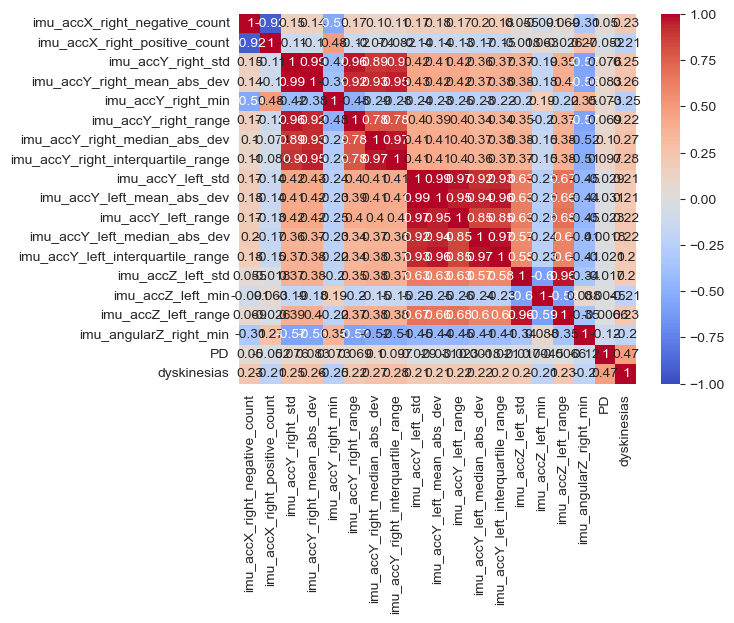

In [245]:
dysk_data = dysk_data[best_correlations_columns]
sns.heatmap(dysk_data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

### Drop of highly correlated columns

In [246]:
correlation = dysk_data.corr().abs()
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['imu_accY_right_mean_abs_dev',
 'imu_accY_right_range',
 'imu_accY_right_interquartile_range',
 'imu_accY_left_mean_abs_dev',
 'imu_accY_left_range',
 'imu_accY_left_interquartile_range',
 'imu_accZ_left_range']

In [247]:
correlation['dyskinesias'].sort_values()

imu_angularZ_right_min                0.202933
imu_accZ_left_std                     0.203277
imu_accY_left_interquartile_range     0.204366
imu_accY_left_mean_abs_dev            0.207382
imu_accZ_left_min                     0.208440
imu_accY_left_std                     0.209200
imu_accX_right_positive_count         0.213650
imu_accY_left_range                   0.219054
imu_accY_right_range                  0.219774
imu_accY_left_median_abs_dev          0.224792
imu_accZ_left_range                   0.227792
imu_accX_right_negative_count         0.228905
imu_accY_right_std                    0.250275
imu_accY_right_min                    0.253398
imu_accY_right_mean_abs_dev           0.262329
imu_accY_right_median_abs_dev         0.269521
imu_accY_right_interquartile_range    0.277420
PD                                    0.469593
dyskinesias                           1.000000
Name: dyskinesias, dtype: float64

In [248]:
len(to_drop)

7

In [249]:
dysk_data.drop(to_drop, axis=1, inplace=True)

In [250]:
#PD is not the target of this module so it will be deleted
dysk_data.drop(columns=['PD'], inplace=True)

<Axes: >

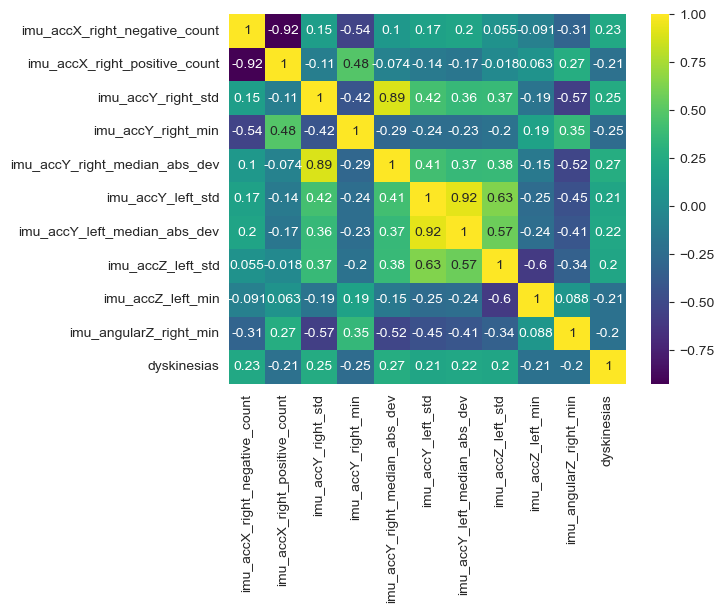

In [251]:
sns.heatmap(dysk_data.corr(), annot = True, cmap= 'viridis')

## Features Mirroring
Due to the chosen features only focused on left limb and spine, is necessary to keep on mind that a patient could
have dyskinesias on his right limb and using the selected features is not possible to identify that PD symptom. As
an alternative for this problem we will add all the symmetric features (if mean_left is present, then mean_right 
will also be included)

In [252]:
pattern_left = re.compile(".*.left")
left_cols = list(filter(pattern_left.match, dysk_data.columns.tolist()))
right_cols = [col.replace('left', 'right') for col in left_cols]

for col in right_cols:
    dysk_data[col] = temp[col]

In [253]:
dysk_data.columns

Index(['imu_accX_right_negative_count', 'imu_accX_right_positive_count',
       'imu_accY_right_std', 'imu_accY_right_min',
       'imu_accY_right_median_abs_dev', 'imu_accY_left_std',
       'imu_accY_left_median_abs_dev', 'imu_accZ_left_std',
       'imu_accZ_left_min', 'imu_angularZ_right_min', 'dyskinesias',
       'imu_accZ_right_std', 'imu_accZ_right_min'],
      dtype='object')

In [254]:
dysk_col = dysk_data.pop('dyskinesias')
dysk_data.insert(len(dysk_data.columns), 'dyskinesias', dysk_col)

<Axes: >

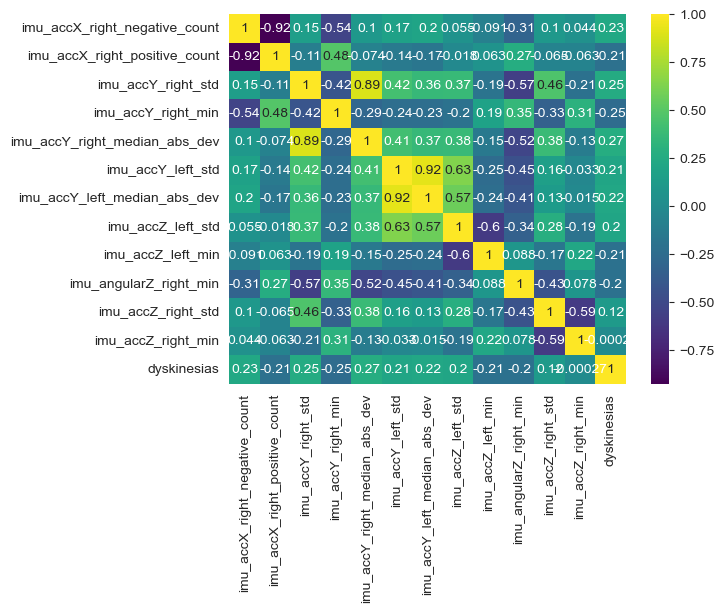

In [255]:
sns.heatmap(dysk_data.corr(), annot = True, cmap= 'viridis')

## Save data

In [256]:
save_path = str(ROOT_DIR) + '/data/processed/dysk-features/'
os.makedirs(save_path, exist_ok=True)

save_and_split(dysk_data, 'dysk-features')